In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import wrangle
import evaluate

pd.options.display.max_columns = None

In [213]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression

The Plan:
- Parametric model age to structure value
- Linear model structure sqft to structure value
- Linear model structure value to tax value.
- Predict in sequence for final prediction

In [214]:
train, test, validate = wrangle.wrangle_zillow()

# Baselines

#### Baseline 1 - Structure value

In [215]:
base_home = train.tax_structure.mean()
base_home

178077.97738077366

#### Baseline 1 - Total value

In [216]:
base_total = train.tax.mean()
base_total

471572.02291948156

# Ensemble 1

### Part 1:  Age for Structure value

In [217]:
x1_train = train[['age','age']] # PolynomialFeatures only accepts 2d arrays, so duplicate the column.
y1_train = train.tax_structure
x1_train

,age,age
6816,70,70
50406,63,63
23474,61,61
14242,31,31
35766,50,50
...,...,...
10747,93,93
36141,90,90
19062,65,65
26838,59,59


In [218]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=False)
x1_train_p = poly.fit_transform(x1_train)

In [219]:
model1 = LinearRegression(positive=False)
model1.fit(x1_train_p, y1_train)


LinearRegression()

In [220]:
train_pred = model1.predict(x1_train_p)
baseline = np.full_like(y1_train, y1_train.mean())

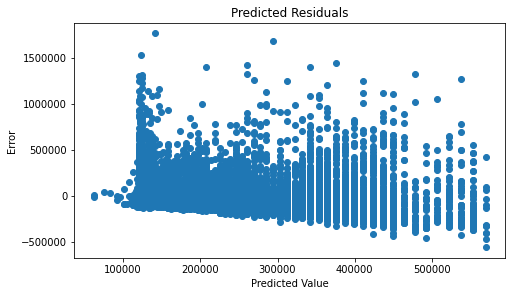

In [221]:
evaluate.plot_residuals(y1_train, train_pred)

In [222]:
model1.coef_

array([-3.11829987e+06,  3.10096735e+06, -1.28331887e+09,  6.41659539e+08,
        6.41659539e+08, -2.82638382e+11, -2.82259435e+11,  2.77663060e+11,
        2.87234757e+11])

This model alone predicts $24,154 closer on average.

In [223]:
def get_model1_x_x2_y(df, poly):
    x = df[['age','age']]
    x2 = poly.transform(x)
    y = df.tax_structure
    return x, x2, y

x1_test, x1_test_p, y1_test = get_model1_x_x2_y(test, poly)
x1_test.shape, x1_test_p.shape, y1_test.shape

((15224, 2), (15224, 9), (15224,))

In [224]:
print(evaluate.baseline_mean_errors(y1_train)['RMSE'] , evaluate.regression_errors(y1_train, train_pred)['RMSE'])
print(evaluate.baseline_mean_errors(y1_train)['RMSE'] - evaluate.regression_errors(y1_train, train_pred)['RMSE'])

171911.9318516087 147049.89746474734
24862.03438686137


In [225]:
test_pred = model1.predict(x1_test_p)
print( evaluate.baseline_mean_errors(y1_test)['RMSE'],  evaluate.regression_errors(y1_test, test_pred)['RMSE']) 
print( evaluate.baseline_mean_errors(y1_test)['RMSE'] -  evaluate.regression_errors(y1_test, test_pred)['RMSE']) 

254264.35446570627 234186.41701907644
20077.937446629832


### Part 2:  Structure Square Feet for Structure value

In [226]:
def get_model2_x_y(df):
    x = df[['structure_sqft','structure_sqft']]
    y = df.tax_structure
    return x, y

x2_train, y2_train = get_model2_x_y(train)
x2_test, y2_test = get_model2_x_y(test)

In [227]:
model2= LinearRegression(positive=True)
model2.fit(x2_train, y2_train)


LinearRegression(positive=True)

In [228]:
train_pred2 = model2.predict(x2_train)
test_pred2 = model2.predict(x2_test)

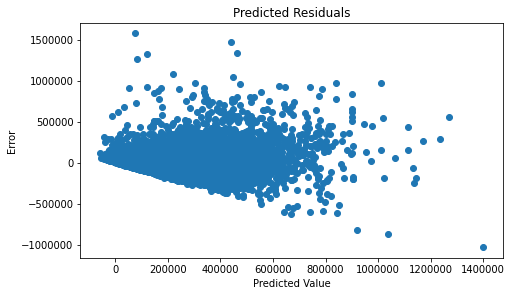

In [229]:
evaluate.plot_residuals(y2_train, train_pred2)

In [230]:
print('Train')
print(evaluate.baseline_mean_errors(y2_train)['RMSE'] , evaluate.regression_errors(y2_train, train_pred2)['RMSE'])
print(evaluate.baseline_mean_errors(y2_train)['RMSE'] - evaluate.regression_errors(y2_train, train_pred2)['RMSE'])
print('Test')
print( evaluate.baseline_mean_errors(y2_test)['RMSE'],  evaluate.regression_errors(y2_test, test_pred2)['RMSE']) 
print( evaluate.baseline_mean_errors(y2_test)['RMSE'] -  evaluate.regression_errors(y2_test, test_pred2)['RMSE']) 

Train
171911.9318516087 108729.70431803926
63182.22753356944
Test
254264.35446570627 166969.92003626574
87294.43442944053


### Bringing them together

In [231]:
mean_pred_train = (train_pred + train_pred2)/2
mean_pred_test = (test_pred + test_pred2)/2

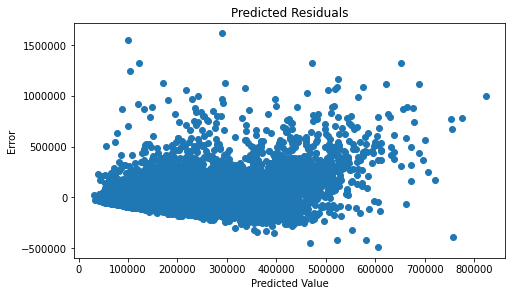

In [232]:
evaluate.plot_residuals(y1_train, mean_pred_train)

In [233]:
print('RMSE for average of two models')
print('Train')
print(evaluate.baseline_mean_errors(train.tax_structure)['RMSE'] , evaluate.regression_errors(train.tax_structure, mean_pred_train)['RMSE'])
print(evaluate.baseline_mean_errors(train.tax_structure)['RMSE'] - evaluate.regression_errors(train.tax_structure, mean_pred_train)['RMSE'])
print('Test')
print(evaluate.baseline_mean_errors(test.tax_structure)['RMSE'] , evaluate.regression_errors(test.tax_structure, mean_pred_test)['RMSE'])
print(evaluate.baseline_mean_errors(test.tax_structure)['RMSE'] - evaluate.regression_errors(test.tax_structure, mean_pred_test)['RMSE'])


RMSE for average of two models
Train
171911.9318516087 115179.90187056967
56732.02998103904
Test
254264.35446570627 191839.30337799297
62425.051087713306


### Part 3:  Predicting overall tax value from predicted structure value

In [234]:
def get_model3_x_y(df):
    x = df[['tax_structure','tax_structure']]
    y = df.tax
    return x, y

In [235]:
x3_train, y3_train = get_model3_x_y(train)
x3_test, y3_test = get_model3_x_y(test)

In [236]:
model3= LinearRegression(positive=True)
model3.fit(x3_train, y3_train)

LinearRegression(positive=True)

In [237]:
train_pred3 = model3.predict(x3_train)
test_pred3 = model3.predict(x3_test)

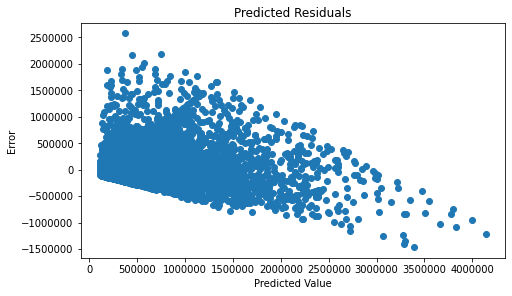

In [238]:
evaluate.plot_residuals(y3_train, train_pred3)


In [239]:
print('Train')
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] , evaluate.regression_errors(y3_train, train_pred3)['RMSE'])
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] - evaluate.regression_errors(y3_train, train_pred3)['RMSE'])
print('Test')
print( evaluate.baseline_mean_errors(y3_test)['RMSE'],  evaluate.regression_errors(y3_test, test_pred3)['RMSE']) 
print( evaluate.baseline_mean_errors(y3_test)['RMSE'] -  evaluate.regression_errors(y3_test, test_pred3)['RMSE']) 

Train
431743.70341977384 251784.3504859854
179959.35293378844
Test
683807.8461676383 374337.66141853295
309470.18474910536


In [240]:
pd.concat((pd.DataFrame(mean_pred_train),pd.DataFrame(mean_pred_train)),axis=1)

,0,0
0,94579.796669,94579.796669
1,167388.901698,167388.901698
2,175774.409314,175774.409314
3,209685.386466,209685.386466
4,227805.686766,227805.686766
...,...,...
19978,71873.573208,71873.573208
19979,160042.717792,160042.717792
19980,102741.710059,102741.710059
19981,150833.808948,150833.808948


In [241]:
train_pred3_p = model3.predict(pd.concat((pd.DataFrame(mean_pred_train),pd.DataFrame(mean_pred_train)),axis=1))
test_pred3_p = model3.predict(pd.concat((pd.DataFrame(mean_pred_test),pd.DataFrame(mean_pred_test)),axis=1))
print('Train')
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] , evaluate.regression_errors(y3_train, train_pred3_p)['RMSE'])
print(evaluate.baseline_mean_errors(y3_train)['RMSE'] - evaluate.regression_errors(y3_train, train_pred3_p)['RMSE'])
print('Test')
print( evaluate.baseline_mean_errors(y3_test)['RMSE'],  evaluate.regression_errors(y3_test, test_pred3_p)['RMSE']) 
print( evaluate.baseline_mean_errors(y3_test)['RMSE'] -  evaluate.regression_errors(y3_test, test_pred3_p)['RMSE']) 

Train
431743.70341977384 359955.1418668994
71788.56155287445
Test
683807.8461676383 588954.577481706
94853.26868593227


c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


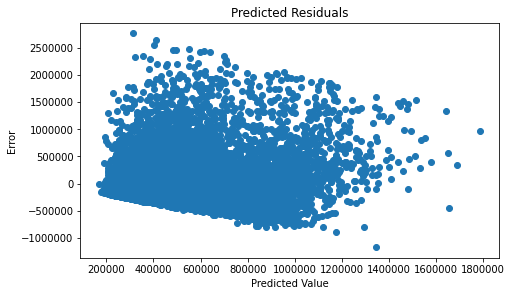

In [242]:
evaluate.plot_residuals(y3_train, train_pred3_p)

## Model 2

### Try sqft, age, bathroom_sum together

In [243]:
scaler = MinMaxScaler()

train_x = scaler.fit_transform(train[['age','structure_sqft','bathroom_sum']])
train_x = pd.DataFrame(train_x, columns=['age','structure_sqft','bathroom_sum'])
train_x

,age,structure_sqft,bathroom_sum
0,0.523077,0.087544,0.000000
1,0.469231,0.184238,0.142857
2,0.453846,0.194219,0.285714
3,0.223077,0.164275,0.285714
4,0.369231,0.250676,0.285714
...,...,...,...
19978,0.700000,0.054065,0.000000
19979,0.676923,0.175296,0.142857
19980,0.484615,0.096902,0.142857
19981,0.438462,0.158245,0.142857


In [244]:
poly = PolynomialFeatures(3)
age = np.array(train_x.age)
age = age.reshape((age.shape[0], 1))
age.shape, train.structure_sqft.shape

age_poly = poly.fit_transform(age)
age_poly = pd.DataFrame(age_poly)
age_poly


,0,1,2,3
0,1.0,0.523077,0.273609,0.143119
1,1.0,0.469231,0.220178,0.103314
2,1.0,0.453846,0.205976,0.093482
3,1.0,0.223077,0.049763,0.011101
4,1.0,0.369231,0.136331,0.050338
...,...,...,...,...
19978,1.0,0.700000,0.490000,0.343000
19979,1.0,0.676923,0.458225,0.310183
19980,1.0,0.484615,0.234852,0.113813
19981,1.0,0.438462,0.192249,0.084294


In [245]:
train_x = train_x.drop(columns='age')
train_x = pd.concat((train_x,age_poly), axis=1)
train_x

,structure_sqft,bathroom_sum,0,1,2,3
0,0.087544,0.000000,1.0,0.523077,0.273609,0.143119
1,0.184238,0.142857,1.0,0.469231,0.220178,0.103314
2,0.194219,0.285714,1.0,0.453846,0.205976,0.093482
3,0.164275,0.285714,1.0,0.223077,0.049763,0.011101
4,0.250676,0.285714,1.0,0.369231,0.136331,0.050338
...,...,...,...,...,...,...
19978,0.054065,0.000000,1.0,0.700000,0.490000,0.343000
19979,0.175296,0.142857,1.0,0.676923,0.458225,0.310183
19980,0.096902,0.142857,1.0,0.484615,0.234852,0.113813
19981,0.158245,0.142857,1.0,0.438462,0.192249,0.084294


In [246]:
model4 = LinearRegression(positive=True)
train_y = train.tax

model4.fit(train_x, train_y)
train_pred4 = model4.predict(train_x)

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


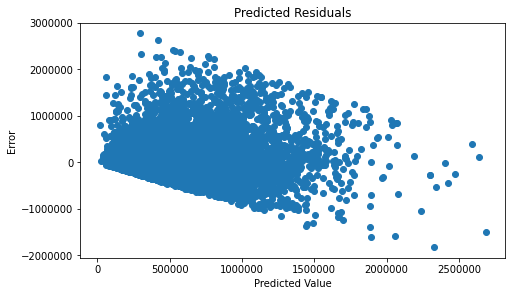

In [247]:
evaluate.plot_residuals(train_y, train_pred4)

In [248]:
print(evaluate.baseline_mean_errors(train_y)['RMSE'] , evaluate.regression_errors(train_y, train_pred4)['RMSE'])
print(evaluate.baseline_mean_errors(train_y)['RMSE'] - evaluate.regression_errors(train_y, train_pred4)['RMSE'])

431743.70341977384 339546.4667676407
92197.23665213311
